## Combined Notebook ##
Tobias Beidler-Shenk, Nick Usme, Ram Adesara

Insert general explanation of how each of the parts work
- Talk about our scoring methodology
- Talk about weights and the survey
- Talk about how we will incorporate all the scores into one final score

In [2]:
import pandas as pd
import numpy as np
import geopandas as geo
%matplotlib inline
import matplotlib.pyplot as plt

transportation = pd.read_csv('transportation.csv', index_col = "Neighborhood")
weights = pd.read_csv("weights.csv", index_col = "Timestamp")

## Metric #1: Transporation ##
First up: measuring the efficacy of a neighborhood's public transportation. We only used one column of data for this: the percentage of people who take public transportation to work. The more people who take it to work in a neighborhood, the stronger we consider that neighborhood's public transit routes to be, and so it receives a higher public transit score. Those scores are then multiplied by our public transportation "weight" that we received from the survey.

In [4]:
# Removes percentage signs, so we can order numerically:
count = 0
for x in transportation['Commute to Work: Public Transportation (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 11] = float(x)
    count+=1

# Displays top 8 scores, after weight:
pt_scores = transportation.sort_values(by=['Commute to Work: Public Transportation (2010)'], ascending = False).iloc[0:, 11:12]
pt_scores["Public Transit Scores"] = np.nan
#transit_scale = 100/pt_scores.iloc[0,0]
for x in range (len(pt_scores)):
    pt_scores.iloc[x,1] = pt_scores.iloc[x,0] * weights.iloc[len(weights)-1, 0]
pt_scores.head(8)

,Commute to Work: Public Transportation (2010),Public Transit Scores
Neighborhood,,
Arlington Heights,88.9,386.255172
Northview Heights,77.4,336.289655
St. Clair,55,238.965517
Middle Hill,48.3,209.855172
Terrace Village,45.2,196.386207
Beltzhoover,43.1,187.262069
Manchester,41.7,181.179310
California-Kirkbride,41,178.137931


Next, we look at how driver-friendly each neighborhood is. We take three variables into account here: the street density of each neighborhood (total length of streets for a given area), the percentage of people who drive to work, and the number of residential parking areas afforded to residents of the neighborhood.

In [5]:
# Street Density sorting
street_density = transportation.sort_values(by=['Street Density (st. mi/area sq. mi)'], ascending = False).iloc[0:, 4:5]

# Driving Percentages sorting (removes percentage signs)
count = 0
for x in transportation['Commute to Work: Drive Alone (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 9] = float(x)
    count+=1
driving_percentages = transportation.sort_values(by=['Commute to Work: Drive Alone (2010)'], ascending = False).iloc[0:, 9:10]

# Parking areas sorting (adds up totals)
for x in range (len(transportation)):
    if (transportation.iloc[x, 7] == "None"):
        transportation.iloc[x, 7] = 0;
    else:
        transportation.iloc[x, 7] = len(str(transportation.iloc[x, 7]).split(','))
parking_available = transportation.sort_values(by=['Res. Permit Parking Area(s)'], ascending = False).iloc[0:, 7:8]

scores_before_scaling = pd.concat([street_density, parking_available, driving_percentages], axis = 1, join='inner')
scores_before_scaling

,Street Density (st. mi/area sq. mi),Res. Permit Parking Area(s),Commute to Work: Drive Alone (2010)
Neighborhood,,,
East Allegheny,71.8,1,44.3
Bluff,50.4,1,25.5
Central Business District,48.2,0,24.8
Knoxville,47.7,0,48.4
Central Northside,47.0,1,47.9
...,...,...,...
East Carnegie,12.9,0,100
Fairywood,9.4,0,42.2
Arlington Heights,8.2,0,11.1


It doesn't make sense to simply add these scores together to recieve a total driving score; for example, the most residential parking areas a neighborhood has is 5. Therefore, we need to scale these scores up relative to one another, so that they each occupy an equal part of the driving score. Then, we multiply the averaged scores by the "driving weight" from our survey to get final driving scores.

In [6]:
# Scales up the values so they each represent an equal part of the score (each out of 100, like percentages)
parking_scale = 100/parking_available.iloc[0]
density_scale = 100/street_density.iloc[0]
driving_scale = 100/driving_percentages.iloc[0]
for x in range (len(parking_available)):
    parking_available.iloc[x] = parking_available.iloc[x] * parking_scale
    street_density.iloc[x] = street_density.iloc[x] * density_scale
    driving_percentages.iloc[x] = driving_percentages.iloc[x] * driving_scale

# Averages the three values for each neighborhood (street density, parking areas available and driving percentages) 
# and multiplies the result by the weight from the survey
driving_scores = pd.concat([street_density, parking_available, driving_percentages], axis = 1, join='inner')
driving_scores["Driving Scores"] = np.nan 
for x in range(len(driving_scores)):
    driving_scores.iloc[x,3] = 0
    for y in range(3):
        driving_scores.iloc[x,3] += driving_scores.iloc[x,y]
    driving_scores.iloc[x,3] = (driving_scores.iloc[x,3]/3) * weights.iloc[len(weights)-1, 1]
    
# Displays top 8 scores, after weight and scaling:
driving_scores.sort_values(by=['Driving Scores'], ascending = False).head(8)

4.344827586


,Street Density (st. mi/area sq. mi),Res. Permit Parking Area(s),Commute to Work: Drive Alone (2010),Driving Scores
Neighborhood,,,,
Shadyside,41.225627,100,44.8,233.066590
East Allegheny,100.000000,20,44.3,205.847126
North Shore,62.534819,20,72,193.612589
Mount Washington,41.782730,40,65,183.900202
Crawford-Roberts,59.888579,20,65.4,182.028220
Bloomfield,62.952646,40,42,181.607338
South Oakland,52.646240,40,46.6,174.457932
Squirrel Hill North,30.222841,60,47.5,172.549307


The last factor for the transportation metric that we choose to look at is how good a neighborhood is for walkers/bikers. We take two variables into account here: firstly, the percentage of people who bike to work, and secondly the percentage of people who walk to work. We average these together, after scaling them proportionally to one another as we did for driving scores, and multiply them by the "walking/biking" weight from the survey. 

In [9]:
# Walking scores
count = 0
for x in transportation['Commute to Work: Walk (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 15] = float(x)
    count+=1
walking = transportation.sort_values(by=['Commute to Work: Walk (2010)'], ascending = False).iloc[0:, 15:16]

# Biking scores
count = 0
for x in transportation['Commute to Work: Bicycle (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 14] = float(x)
    count+=1
biking = transportation.sort_values(by=['Commute to Work: Bicycle (2010)'], ascending = False).iloc[0:, 14:15]

bw_before_scaling = pd.concat([walking, biking], axis = 1, join='inner')
bw_before_scaling

,Commute to Work: Walk (2010),Commute to Work: Bicycle (2010)
Neighborhood,,
Central Oakland,62.4,0
North Oakland,52.6,2.9
Allegheny Center,43.8,0
Bluff,43.1,0
Central Business District,42,0
...,...,...
West End,0,0
Arlington Heights,0,0
Allentown,0,0


In [11]:
# Scales up the values for walking/biking so they each represent an equal part of the score:
walking_scale = 100/walking.iloc[0]
biking_scale = 100/biking.iloc[0]
for x in range (len(walking)):
    walking.iloc[x] = walking.iloc[x] * walking_scale
    biking.iloc[x] = biking.iloc[x] * biking_scale

# Averages the two values for each neighborhood (biking and walking percentages) and multiplies the result by the weight from the survey:
bw_scores = pd.concat([walking, biking], axis = 1, join='inner')
bw_scores["Biking/Walking Scores"] = np.nan 
for x in range(len(bw_scores)):
    bw_scores.iloc[x,2] = 0
    for y in range(2):
        bw_scores.iloc[x,2] += bw_scores.iloc[x,y]
    bw_scores.iloc[x,2] = (bw_scores.iloc[x,2]/2) * weights.iloc[len(weights)-1, 2]

# Displays the top 8 scores, after weight:
bw_scores.sort_values(by=['Biking/Walking Scores'], ascending = False).head(8)

,Commute to Work: Walk (2010),Commute to Work: Bicycle (2010),Biking/Walking Scores
Neighborhood,,,
North Oakland,84.2949,38.6667,266.416667
Lower Lawrenceville,21.9551,100,264.236111
Bloomfield,30.1282,85.3333,250.166667
Central Oakland,100,0,216.666667
Friendship,32.2115,65.3333,211.347222
Spring Hill-City View,7.05128,84,197.277778
Spring Garden,20.0321,69.3333,193.625000
Allegheny Center,70.1923,0,152.083333


Now, we combine all three scores into one to make one big "transportation score". Below are the scores, in addition to a geopandas graphic.

In [17]:
overall_scores = pd.read_csv('transportation_scores.csv', index_col = 'Neighborhood')
overall_scores.head(8)

,Public Transit Scores,Driving Scores,Biking/Walking Scores,Overall
Neighborhood,,,,
Arlington Heights,386.255172,28.215480,0.000000,414.470653
Northview Heights,336.289655,42.805699,19.791667,398.887021
St. Clair,238.965517,63.192290,34.722222,336.880030
Middle Hill,209.855172,127.022534,14.236111,351.113817
Terrace Village,196.386207,58.287238,108.333333,363.006778
Beltzhoover,187.262069,128.924529,0.000000,316.186598
Manchester,181.179310,114.601636,40.277778,336.058724
California-Kirkbride,178.137931,108.181968,47.569444,333.889343


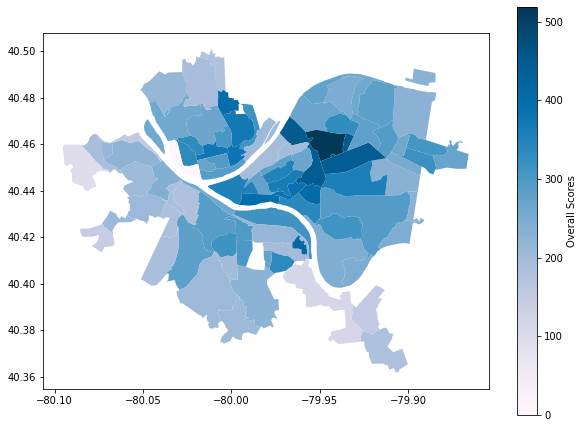

In [19]:
# Geopandas representation
final_scores = overall_scores.groupby("Neighborhood").sum()['Overall']
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
final_map = neighborhoods.merge(final_scores, how='left', left_on='hood', right_on='Neighborhood')
final_map.plot(column='Overall',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Overall Scores"}
                  )

## Metric #2: Health and Safety

## Metric #3: Housing

## Combined Results

Using the individual scores from the three metrics (transportation, health/safety and housing), we can now combine them into one massive score for each neighborhood, giving us the best neighborhoods overall. Transportation and health/safety scores are added to final scoring, while 